## learning-AI : deep learning application (61357002)
### PT : MNIST DCGAN

**MNIST 데이터셋을 이용하여 DCGAN 실습**

<br>

- **임규연 (lky473736)**
- 2024.10.30.에 문서 작성
- **Reference**
    - https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/dcgan.ipynb
    - https://cs229.stanford.edu/proj2018/report/42.pdf
   

## <span id='dl'><mark>DL</mark></span>

MNIST dataset을 이용하여 적대적 생성 신경망인 **GAN : Generative Adversarial Networks을 실습**해본다. GAN은 두 개의 신경망, 즉 **생성기(Generator)와 판별기(Discriminator)로 구성**되어 있다. 생성기는 랜덤 노이즈(z)를 입력으로 받아 가짜 이미지를 생성하는 역할을 하며, 그 목표는 판별기를 속일 수 있는 진짜 같은 이미지를 만들어내는 것이다. 반면, 판별기는 진짜 이미지와 생성기가 만든 가짜 이미지를 입력받아 이들이 진짜인지 가짜인지 구별하는 역할을 하며, 진짜와 가짜 이미지를 정확히 분류하는 것이 목표이다.

<br>

GAN 중에서 CNN, Convolution neural network으로만 구성된 DCGAN을 본 노트북 파일에서 실습한다. DCGAN은 깊은 컨볼루션 신경망을 기반으로 하여 이미지 생성 품질을 향상시키는 모델이다. 이 모델은 컨볼루션 레이어를 사용하여 생성기와 판별기를 구성하며, 이는 고해상도의 이미지를 생성하는 데 유리하다.


In [143]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm
from tensorflow.keras import layers, models, optimizers
import time

In [144]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


In [145]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Flatten
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam


In [147]:

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D,  Dropout, Flatten, Dense, Input
from keras.layers import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Flatten, Dense, Input, LeakyReLU, Activation, BatchNormalization, Reshape, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop


In [148]:
tf.config.run_functions_eagerly(True)  # Eager Execution 활성화

-----

### DCGAN

<img src="https://camo.githubusercontent.com/cc94c3aa25068d89dcdbd6cc32066d41281ac226a6a6713bd098d5ee79cc55c1/68747470733a2f2f70726f64756374696f6e2d6d656469612e70617065727377697468636f64652e636f6d2f6d6574686f64732f53637265656e5f53686f745f323032302d30372d30315f61745f31312e32372e35315f504d5f496f47626f31692e706e67" width="400px">

결국에 DCGAN과 GAN은 위와 같은 구조로 이루어져 있으며, GAN에서 각 Dense layer를 Convolution layer로 변경한 것이다. 둘의 차이를 표로 정리해보자면 아래와 같다.

<img src="comparison_gan_dcgan.png" width="600px">

DCGAN(Deep Convolutional Generative Adversarial Network)과 GAN(Generative Adversarial Network)의 주요 차이점은 아키텍처에 있다. 일반 GAN은 밀집층(Dense Layer)을 사용하여 이미지를 생성하는 반면, DCGAN은 컨볼루션 신경망(CNN)을 기반으로 하여 이미지의 공간적 특성을 더 잘 반영한다. 

DCGAN은 생성자와 판별자 모두에 컨볼루션 레이어를 적용하여 이미지를 생성하고 판별하는 데 있어 더욱 효과적인 성능을 보여준다. 또한, DCGAN은 배치 정규화(Batch Normalization)와 ReLU 활성화 함수를 사용하여 학습 과정을 안정화하고 성능을 개선한다. 이러한 특징 덕분에 DCGAN은 보다 선명하고 품질 높은 이미지를 생성하는 데 유리하다.

In [149]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [150]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [151]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
     

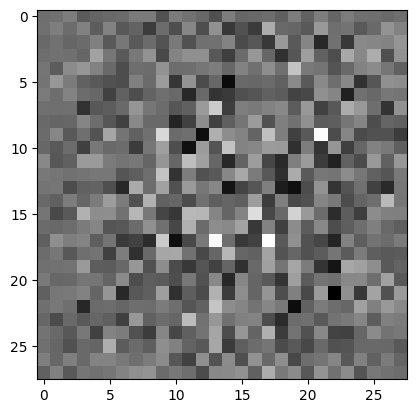

In [152]:
'''
    아직 훈련하지 않은 generator를 이용하여 이미지 생성하기
'''

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [153]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [154]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

'''
    진짜 이미지 : 양수
    가짜 이미지 : 음수
'''

tf.Tensor([[0.00175266]], shape=(1, 1), dtype=float32)


'\n    진짜 이미지 : 양수\n    가짜 이미지 : 음수\n'

In [155]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # 두 함수의 optimizer

In [156]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

'''
    discriminator가 가짜 이미지와 진짜 이미지를 얼마나 잘 판별하는지 수치화
    진짜 이미지에 대한 예측과 1로 이루어진 배열을 비교하고, 가짜로 (생성된) 이미지에 대한 예측과 0으로 이루어진 배열을 비교
'''

'\n    discriminator가 가짜 이미지와 진짜 이미지를 얼마나 잘 판별하는지 수치화\n    진짜 이미지에 대한 예측과 1로 이루어진 배열을 비교하고, 가짜로 (생성된) 이미지에 대한 예측과 0으로 이루어진 배열을 비교\n'

In [157]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

'''
    직관적으로, 생성자가 잘 작동하면 판별자는 가짜 이미지를 실제(또는 1)로 분류
'''

'\n    직관적으로, 생성자가 잘 작동하면 판별자는 가짜 이미지를 실제(또는 1)로 분류\n'

In [158]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) # 둘을 별도로 훈련하니깐 당연히 optimizer도 각각 있어야함

In [159]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [160]:
generator_losses = []
discriminator_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    generator_losses.append(gen_loss.numpy())
    discriminator_losses.append(disc_loss.numpy())

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [161]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 에폭이 끝날 때마다 손실 출력
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}, Generator Loss: {generator_losses[-1]}, Discriminator Loss: {discriminator_losses[-1]}')
            generate_and_save_images(generator, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)


In [162]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('DCGAN_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Time for epoch 1 is 17.14484143257141 sec
Time for epoch 2 is 16.86144757270813 sec
Time for epoch 3 is 16.84419822692871 sec
Time for epoch 4 is 16.908589363098145 sec
Epoch 5, Generator Loss: 0.8218986988067627, Discriminator Loss: 1.2243280410766602


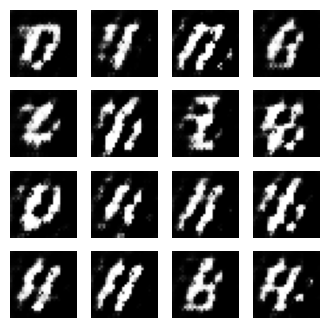

Time for epoch 5 is 17.21735143661499 sec
Time for epoch 6 is 16.87679958343506 sec
Time for epoch 7 is 16.812867879867554 sec
Time for epoch 8 is 16.794564247131348 sec
Time for epoch 9 is 16.69697594642639 sec
Epoch 10, Generator Loss: 1.1284879446029663, Discriminator Loss: 0.9786499738693237


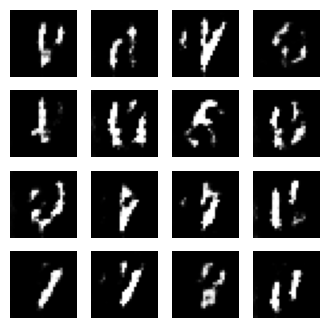

Time for epoch 10 is 17.738507509231567 sec
Time for epoch 11 is 17.04280376434326 sec
Time for epoch 12 is 17.08531641960144 sec
Time for epoch 13 is 17.04109239578247 sec
Time for epoch 14 is 17.07639980316162 sec
Epoch 15, Generator Loss: 1.0472040176391602, Discriminator Loss: 1.0904514789581299


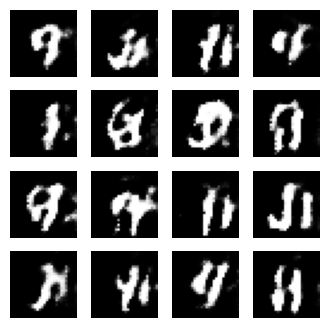

Time for epoch 15 is 17.616268634796143 sec
Time for epoch 16 is 17.147814989089966 sec
Time for epoch 17 is 17.118356466293335 sec
Time for epoch 18 is 17.16513419151306 sec
Time for epoch 19 is 17.077012538909912 sec
Epoch 20, Generator Loss: 1.318080186843872, Discriminator Loss: 1.0253782272338867


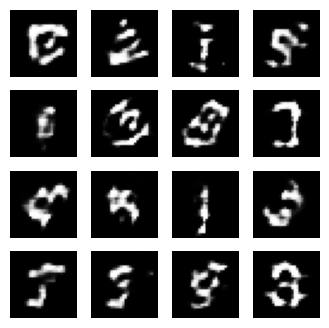

Time for epoch 20 is 17.66086220741272 sec
Time for epoch 21 is 17.33975076675415 sec
Time for epoch 22 is 17.215022087097168 sec
Time for epoch 23 is 17.060524463653564 sec
Time for epoch 24 is 17.034271717071533 sec
Epoch 25, Generator Loss: 1.1886738538742065, Discriminator Loss: 1.155848503112793


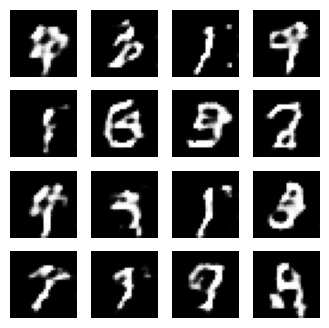

Time for epoch 25 is 17.504537105560303 sec
Time for epoch 26 is 17.029497623443604 sec
Time for epoch 27 is 17.018221616744995 sec
Time for epoch 28 is 17.015570640563965 sec
Time for epoch 29 is 17.069225549697876 sec
Epoch 30, Generator Loss: 1.0766550302505493, Discriminator Loss: 1.1313728094100952


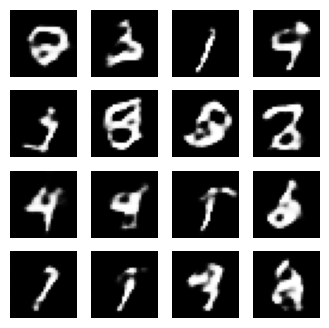

Time for epoch 30 is 17.395954132080078 sec
Time for epoch 31 is 16.886492013931274 sec
Time for epoch 32 is 16.91238236427307 sec
Time for epoch 33 is 16.89509892463684 sec
Time for epoch 34 is 16.853408336639404 sec
Epoch 35, Generator Loss: 0.8837422132492065, Discriminator Loss: 1.229325532913208


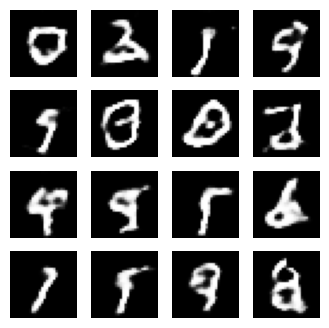

Time for epoch 35 is 17.578413248062134 sec
Time for epoch 36 is 17.043883085250854 sec
Time for epoch 37 is 17.164429426193237 sec
Time for epoch 38 is 17.0243501663208 sec
Time for epoch 39 is 17.018860340118408 sec
Epoch 40, Generator Loss: 1.1005771160125732, Discriminator Loss: 1.0965549945831299


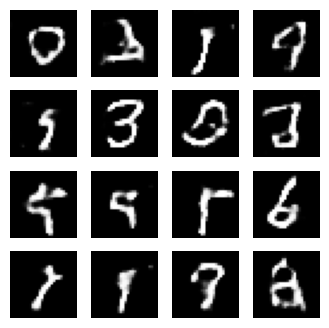

Time for epoch 40 is 17.44094681739807 sec
Time for epoch 41 is 17.07422637939453 sec
Time for epoch 42 is 17.036977291107178 sec
Time for epoch 43 is 17.07440447807312 sec
Time for epoch 44 is 17.231075525283813 sec
Epoch 45, Generator Loss: 0.8931158781051636, Discriminator Loss: 1.2044744491577148


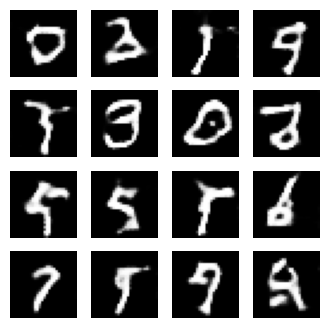

Time for epoch 45 is 17.519861936569214 sec
Time for epoch 46 is 17.110416173934937 sec
Time for epoch 47 is 17.072664737701416 sec
Time for epoch 48 is 17.110418558120728 sec
Time for epoch 49 is 16.9801766872406 sec
Epoch 50, Generator Loss: 1.0303385257720947, Discriminator Loss: 1.164846658706665


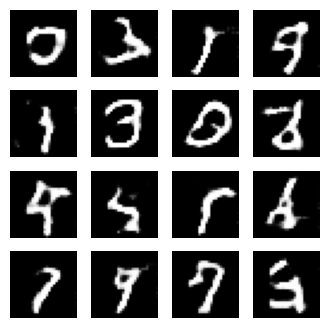

Time for epoch 50 is 17.459829092025757 sec
Time for epoch 51 is 16.986926555633545 sec
Time for epoch 52 is 17.211485385894775 sec
Time for epoch 53 is 17.11365294456482 sec
Time for epoch 54 is 17.15356707572937 sec
Epoch 55, Generator Loss: 0.8949843645095825, Discriminator Loss: 1.3020963668823242


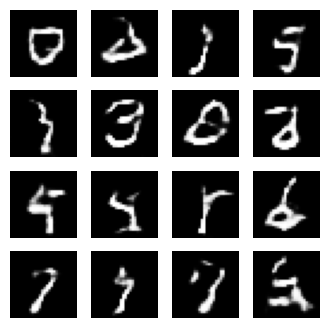

Time for epoch 55 is 17.401413440704346 sec
Time for epoch 56 is 16.842805862426758 sec
Time for epoch 57 is 16.92612648010254 sec
Time for epoch 58 is 16.981974124908447 sec
Time for epoch 59 is 16.995855569839478 sec
Epoch 60, Generator Loss: 0.9374225735664368, Discriminator Loss: 1.1896169185638428


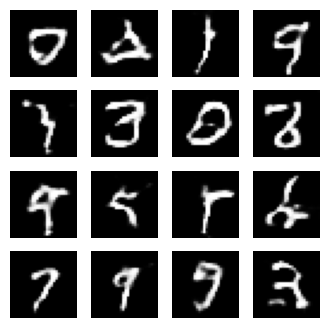

Time for epoch 60 is 17.67192029953003 sec
Time for epoch 61 is 17.103673934936523 sec
Time for epoch 62 is 17.104511737823486 sec
Time for epoch 63 is 16.966362714767456 sec
Time for epoch 64 is 17.061548709869385 sec
Epoch 65, Generator Loss: 1.0468106269836426, Discriminator Loss: 1.1457898616790771


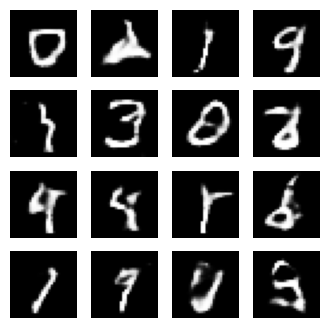

Time for epoch 65 is 17.464085817337036 sec
Time for epoch 66 is 17.078612327575684 sec
Time for epoch 67 is 17.034082889556885 sec
Time for epoch 68 is 16.99985098838806 sec
Time for epoch 69 is 17.014307975769043 sec
Epoch 70, Generator Loss: 0.8962281942367554, Discriminator Loss: 1.2331914901733398


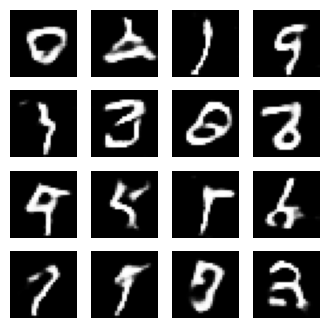

Time for epoch 70 is 17.41815710067749 sec
Time for epoch 71 is 17.170665979385376 sec
Time for epoch 72 is 17.072669744491577 sec
Time for epoch 73 is 17.08789610862732 sec
Time for epoch 74 is 17.130993604660034 sec
Epoch 75, Generator Loss: 0.9038619995117188, Discriminator Loss: 1.232889175415039


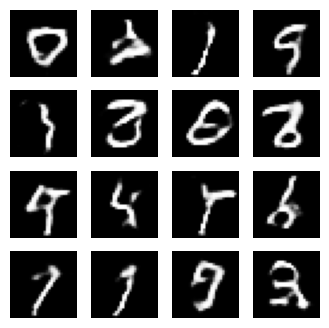

Time for epoch 75 is 17.500874996185303 sec
Time for epoch 76 is 17.049517393112183 sec
Time for epoch 77 is 16.98082947731018 sec
Time for epoch 78 is 16.96928358078003 sec
Time for epoch 79 is 16.99268388748169 sec
Epoch 80, Generator Loss: 0.8551599383354187, Discriminator Loss: 1.310899019241333


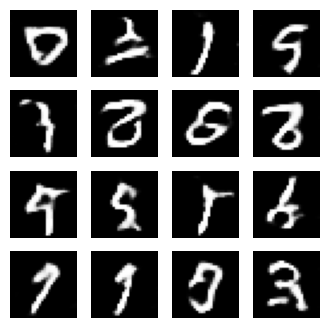

Time for epoch 80 is 17.472712516784668 sec
Time for epoch 81 is 16.986467838287354 sec
Time for epoch 82 is 16.930212020874023 sec
Time for epoch 83 is 17.000232458114624 sec
Time for epoch 84 is 16.939281463623047 sec
Epoch 85, Generator Loss: 0.9770313501358032, Discriminator Loss: 1.165377140045166


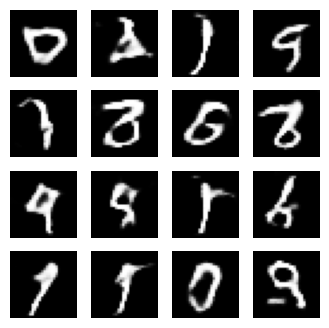

Time for epoch 85 is 17.721733331680298 sec
Time for epoch 86 is 16.96981906890869 sec
Time for epoch 87 is 17.071008682250977 sec
Time for epoch 88 is 17.175298929214478 sec
Time for epoch 89 is 17.178330421447754 sec
Epoch 90, Generator Loss: 0.8603607416152954, Discriminator Loss: 1.247673511505127


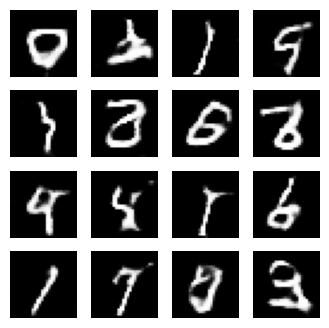

Time for epoch 90 is 17.469585180282593 sec
Time for epoch 91 is 17.163562536239624 sec
Time for epoch 92 is 17.12986469268799 sec
Time for epoch 93 is 17.1185040473938 sec
Time for epoch 94 is 17.09099841117859 sec
Epoch 95, Generator Loss: 0.8563917875289917, Discriminator Loss: 1.2683662176132202


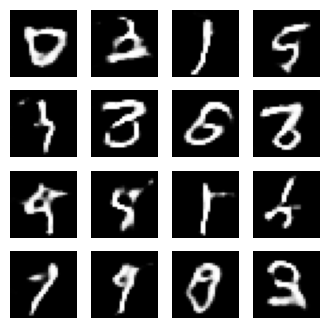

Time for epoch 95 is 17.45949363708496 sec
Time for epoch 96 is 17.165737628936768 sec
Time for epoch 97 is 17.1722252368927 sec
Time for epoch 98 is 17.125126361846924 sec
Time for epoch 99 is 17.189894437789917 sec
Epoch 100, Generator Loss: 1.0063916444778442, Discriminator Loss: 1.0928173065185547


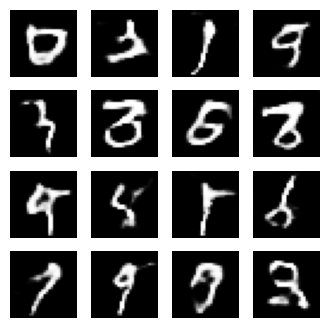

Time for epoch 100 is 17.585346698760986 sec
Time for epoch 101 is 17.03554654121399 sec
Time for epoch 102 is 17.0063259601593 sec
Time for epoch 103 is 17.116941452026367 sec
Time for epoch 104 is 17.036627531051636 sec
Epoch 105, Generator Loss: 0.7950752973556519, Discriminator Loss: 1.2618370056152344


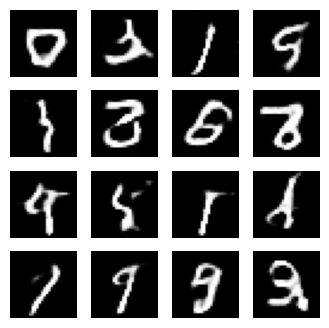

Time for epoch 105 is 17.7981698513031 sec
Time for epoch 106 is 17.01520037651062 sec
Time for epoch 107 is 17.35068702697754 sec
Time for epoch 108 is 17.08743405342102 sec
Time for epoch 109 is 16.984079360961914 sec
Epoch 110, Generator Loss: 0.984375, Discriminator Loss: 1.3402940034866333


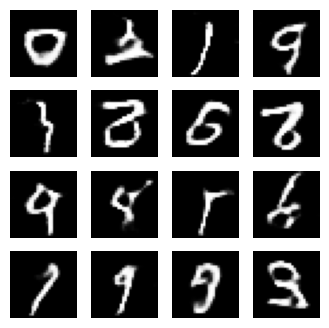

Time for epoch 110 is 17.691879749298096 sec
Time for epoch 111 is 17.074320793151855 sec
Time for epoch 112 is 17.125762224197388 sec
Time for epoch 113 is 17.043989658355713 sec
Time for epoch 114 is 17.078592777252197 sec
Epoch 115, Generator Loss: 0.990410566329956, Discriminator Loss: 1.2077592611312866


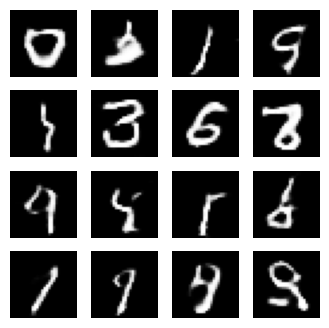

Time for epoch 115 is 17.37444806098938 sec
Time for epoch 116 is 17.053165435791016 sec
Time for epoch 117 is 17.067974090576172 sec
Time for epoch 118 is 17.00192379951477 sec
Time for epoch 119 is 17.001480102539062 sec
Epoch 120, Generator Loss: 0.862684965133667, Discriminator Loss: 1.3500800132751465


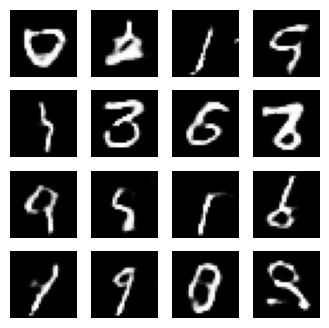

Time for epoch 120 is 17.445003271102905 sec
Time for epoch 121 is 17.128343105316162 sec
Time for epoch 122 is 17.061479806900024 sec
Time for epoch 123 is 17.224912405014038 sec
Time for epoch 124 is 17.208035945892334 sec
Epoch 125, Generator Loss: 0.8199401497840881, Discriminator Loss: 1.3644530773162842


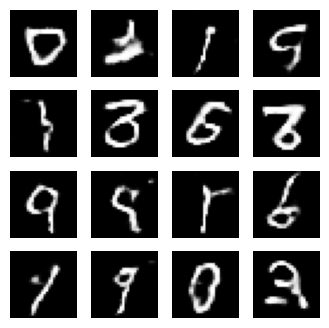

Time for epoch 125 is 17.57233953475952 sec
Time for epoch 126 is 17.101316213607788 sec
Time for epoch 127 is 17.015216827392578 sec
Time for epoch 128 is 17.03291130065918 sec
Time for epoch 129 is 17.046310901641846 sec
Epoch 130, Generator Loss: 0.9795685410499573, Discriminator Loss: 1.3352068662643433


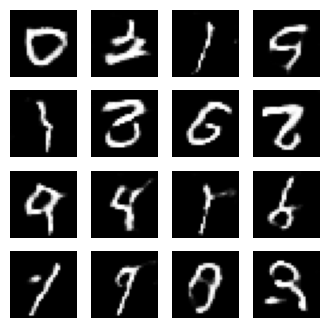

Time for epoch 130 is 17.380937337875366 sec
Time for epoch 131 is 16.93637251853943 sec
Time for epoch 132 is 16.91713047027588 sec
Time for epoch 133 is 16.97014045715332 sec
Time for epoch 134 is 16.93728494644165 sec
Epoch 135, Generator Loss: 0.8423271179199219, Discriminator Loss: 1.253844976425171


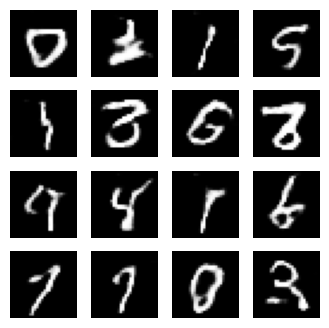

Time for epoch 135 is 17.730631351470947 sec
Time for epoch 136 is 17.086167812347412 sec
Time for epoch 137 is 17.12741208076477 sec
Time for epoch 138 is 16.98611307144165 sec
Time for epoch 139 is 16.970060348510742 sec
Epoch 140, Generator Loss: 0.8535289764404297, Discriminator Loss: 1.3244723081588745


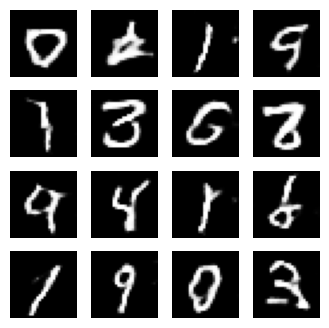

Time for epoch 140 is 17.423311233520508 sec
Time for epoch 141 is 17.036977767944336 sec
Time for epoch 142 is 16.995290279388428 sec
Time for epoch 143 is 17.072554111480713 sec
Time for epoch 144 is 16.987762212753296 sec
Epoch 145, Generator Loss: 1.045181155204773, Discriminator Loss: 1.2949613332748413


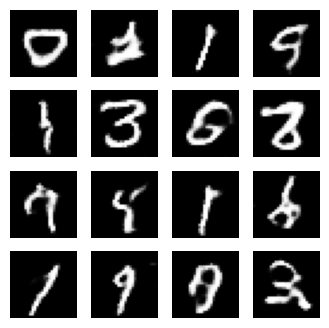

Time for epoch 145 is 17.485360622406006 sec
Time for epoch 146 is 17.139892101287842 sec
Time for epoch 147 is 17.166325569152832 sec
Time for epoch 148 is 17.176841497421265 sec
Time for epoch 149 is 17.157315015792847 sec
Epoch 150, Generator Loss: 0.9569408893585205, Discriminator Loss: 1.2901504039764404


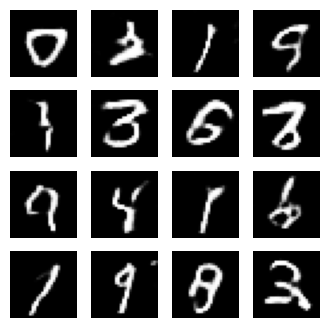

Time for epoch 150 is 17.625298500061035 sec
Time for epoch 151 is 17.041043043136597 sec
Time for epoch 152 is 17.066296339035034 sec
Time for epoch 153 is 17.091430187225342 sec
Time for epoch 154 is 17.099770069122314 sec
Epoch 155, Generator Loss: 0.8952552080154419, Discriminator Loss: 1.2420434951782227


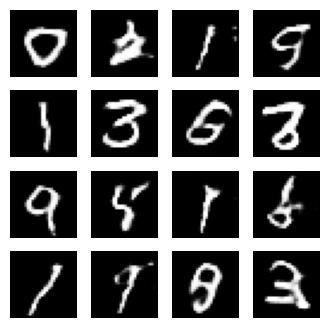

Time for epoch 155 is 17.474106073379517 sec
Time for epoch 156 is 16.99762272834778 sec
Time for epoch 157 is 17.046509265899658 sec
Time for epoch 158 is 17.003732681274414 sec
Time for epoch 159 is 17.028956413269043 sec
Epoch 160, Generator Loss: 0.7939555644989014, Discriminator Loss: 1.2274045944213867


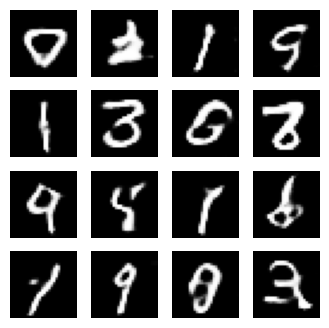

Time for epoch 160 is 17.90971326828003 sec
Time for epoch 161 is 17.193923950195312 sec
Time for epoch 162 is 17.094034671783447 sec
Time for epoch 163 is 17.029066801071167 sec
Time for epoch 164 is 16.988340854644775 sec
Epoch 165, Generator Loss: 0.840598464012146, Discriminator Loss: 1.2282699346542358


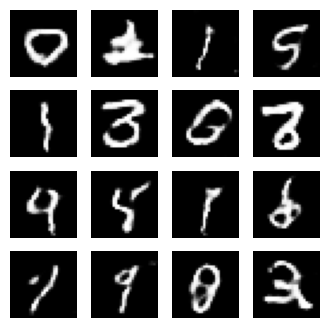

Time for epoch 165 is 17.466356992721558 sec
Time for epoch 166 is 17.04907536506653 sec
Time for epoch 167 is 16.984287977218628 sec
Time for epoch 168 is 17.132205724716187 sec
Time for epoch 169 is 17.100197076797485 sec
Epoch 170, Generator Loss: 0.9747104048728943, Discriminator Loss: 1.2665443420410156


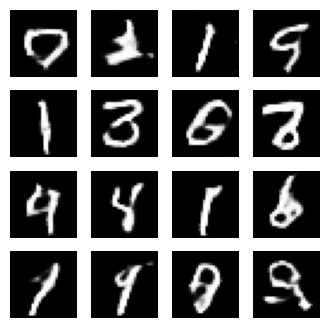

Time for epoch 170 is 17.448102951049805 sec
Time for epoch 171 is 17.04725193977356 sec
Time for epoch 172 is 17.03023934364319 sec
Time for epoch 173 is 17.036680459976196 sec
Time for epoch 174 is 17.071771383285522 sec
Epoch 175, Generator Loss: 0.8620067834854126, Discriminator Loss: 1.210284948348999


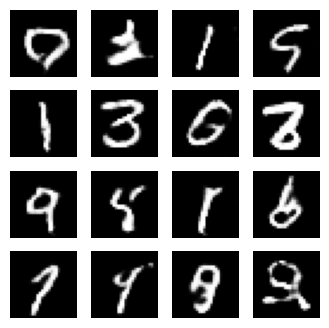

Time for epoch 175 is 17.526185989379883 sec
Time for epoch 176 is 17.00800657272339 sec
Time for epoch 177 is 17.053892374038696 sec
Time for epoch 178 is 17.024365425109863 sec
Time for epoch 179 is 17.13100242614746 sec
Epoch 180, Generator Loss: 0.858866274356842, Discriminator Loss: 1.258971929550171


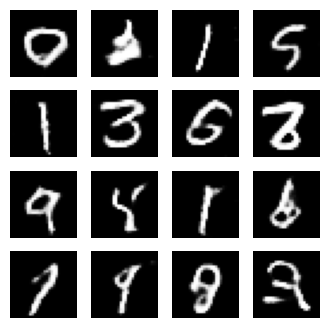

Time for epoch 180 is 17.53287410736084 sec
Time for epoch 181 is 17.088639736175537 sec
Time for epoch 182 is 17.083844661712646 sec
Time for epoch 183 is 17.057002067565918 sec
Time for epoch 184 is 16.919495582580566 sec
Epoch 185, Generator Loss: 0.8539431691169739, Discriminator Loss: 1.410286784172058


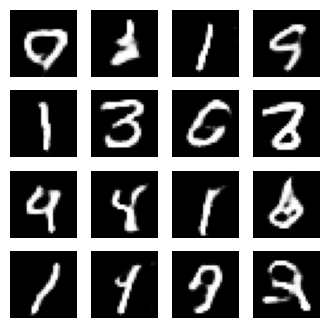

Time for epoch 185 is 17.632381916046143 sec
Time for epoch 186 is 16.926820993423462 sec
Time for epoch 187 is 16.961708545684814 sec
Time for epoch 188 is 17.058497428894043 sec
Time for epoch 189 is 16.979461669921875 sec
Epoch 190, Generator Loss: 0.7850996851921082, Discriminator Loss: 1.3058569431304932


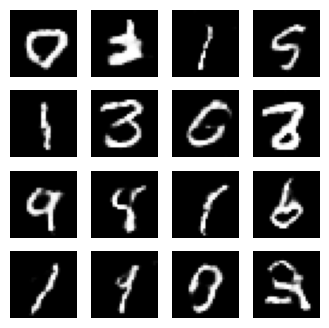

Time for epoch 190 is 17.411420822143555 sec
Time for epoch 191 is 17.099542379379272 sec
Time for epoch 192 is 17.18092703819275 sec
Time for epoch 193 is 17.03817629814148 sec
Time for epoch 194 is 17.05195927619934 sec
Epoch 195, Generator Loss: 0.8585488796234131, Discriminator Loss: 1.224198818206787


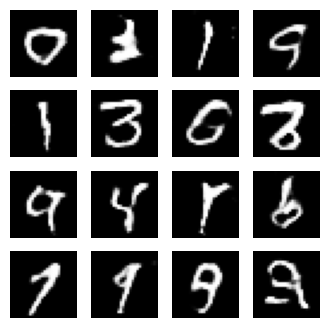

Time for epoch 195 is 17.344621181488037 sec
Time for epoch 196 is 17.176213026046753 sec
Time for epoch 197 is 17.059245586395264 sec
Time for epoch 198 is 17.154823303222656 sec
Time for epoch 199 is 17.234583854675293 sec
Epoch 200, Generator Loss: 0.917481541633606, Discriminator Loss: 1.3075921535491943


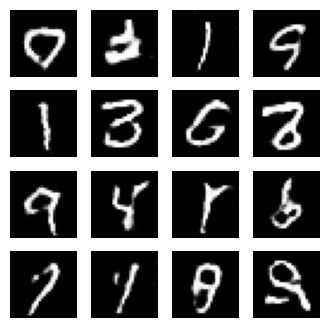

Time for epoch 200 is 17.45561122894287 sec


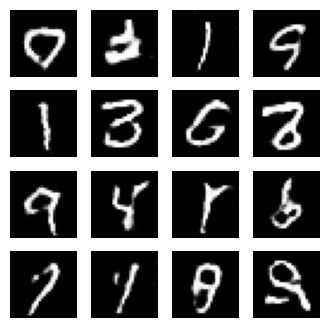

In [163]:
train(train_dataset, EPOCHS)